In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [7]:
data = pd.read_csv('heart.csv').dropna()
data_pd = data.copy()

In [8]:
data1 = data[['age', 'trestbps', 'thalach']]
data1

,age,trestbps,thalach
0,63,145,150
1,37,130,187
2,41,130,172
3,56,120,178
4,57,120,163
...,...,...,...
298,57,140,123
299,45,110,132
300,68,144,141
301,57,130,115


In [9]:
data2 = data[['age', 'trestbps', 'thalach', 'cp', 'chol', 'oldpeak']]
data2

,age,trestbps,thalach,cp,chol,oldpeak
0,63,145,150,3,233,2.3
1,37,130,187,2,250,3.5
2,41,130,172,1,204,1.4
3,56,120,178,1,236,0.8
4,57,120,163,0,354,0.6
...,...,...,...,...,...,...
298,57,140,123,0,241,0.2
299,45,110,132,3,264,1.2
300,68,144,141,0,193,3.4
301,57,130,115,0,131,1.2


In [10]:
target = data['target']

In [11]:
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(data1)
stan_data = {
    'N': predictors_scaled.shape[0],
    'K': predictors_scaled.shape[1],
    'X': predictors_scaled,
    'y': target.values
}

model = CmdStanModel(stan_file='posterior1.stan')

16:15:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:15:07 - cmdstanpy - INFO - CmdStan done processing.



Predicted probability of heart disease: 0.68


/usr/local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


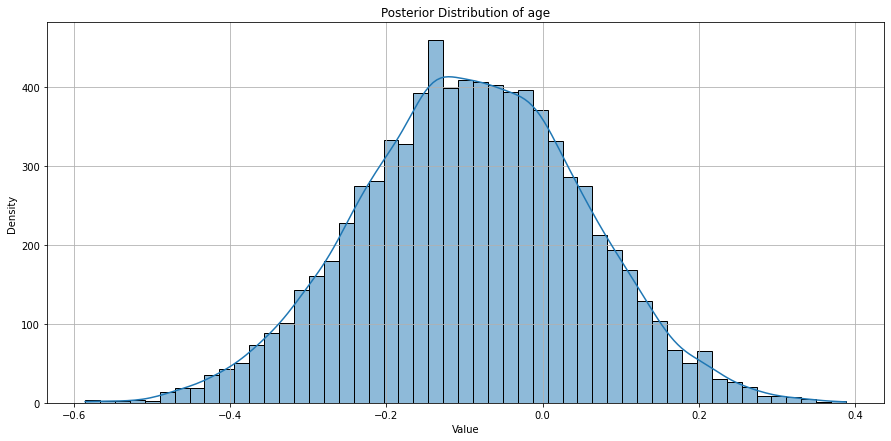

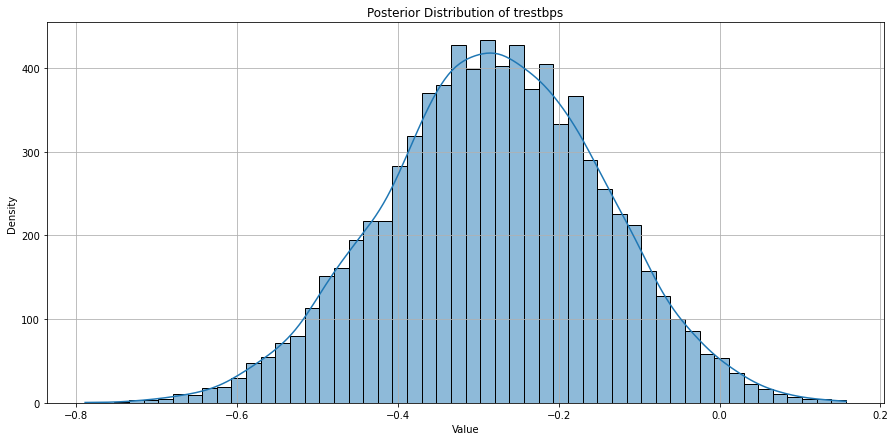

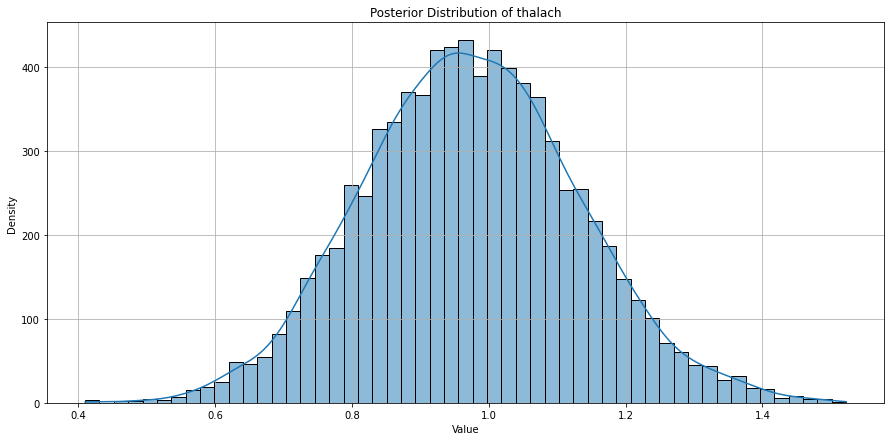

In [12]:
fit = model.sample(data=stan_data, iter_sampling=2000, chains=4)

results = fit.draws_pd()

feature_names = ['age', 'trestbps', 'thalach']
param_names = [f'beta[{i+1}]' for i in range(len(feature_names))]
param_mapping = dict(zip(param_names, feature_names))

beta_columns = [col for col in results.columns if col in param_mapping]

beta_samples = results[beta_columns].values

new_data = np.array([60, 140, 172])  # example new data point
new_data_scaled = scaler.transform([new_data])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Predictive probabilities from posterior samples
pred_probs = sigmoid(np.dot(beta_samples, new_data_scaled.T))

# Aggregate predictions
predicted_prob = np.mean(pred_probs)
print(f'Predicted probability of heart disease: {predicted_prob:.2f}')

# Plot the posterior distributions in separate figures
for column in beta_columns:
    plt.figure(figsize=(15,7))
    sns.histplot(results[column], kde=True)
    param_name = param_mapping[column]
    plt.title(f'Posterior Distribution of {param_name}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [13]:
# Sample from the posterior distribution of the age coefficient
beta_age_samples = results['beta[1]'].values  # Assuming 'beta[1]' corresponds to 'age'

# New data example: age = 60
new_age = 82

# Calculate the linear predictor (log-odds) for each sample
log_odds = beta_age_samples * new_age

# Convert log-odds to probability
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probabilities = sigmoid(log_odds)

# Aggregate the probabilities
predicted_prob = np.mean(probabilities)
print(f'Predicted probability of heart disease for age 60: {predicted_prob:.2f}')

Predicted probability of heart disease for age 60: 0.27


In [14]:
# Sample from the posterior distribution of the trestbps coefficient
beta_trestbps_samples = results['beta[2]'].values  # Assuming 'beta[2]' corresponds to 'trestbps'

# New data example: trestbps = 140
new_trestbps = 140

# Calculate the linear predictor (log-odds) for each sample
log_odds = beta_trestbps_samples * new_trestbps

# Convert log-odds to probability
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probabilities = sigmoid(log_odds)

# Aggregate the probabilities
predicted_prob = np.mean(probabilities)
print(f'Predicted probability of heart disease for trestbps 140: {predicted_prob:.2f}')

Predicted probability of heart disease for trestbps 140: 0.02
